In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [5]:
train = pd.read_csv("./predictprice/train.csv")
test = pd.read_csv("./predictprice/test.csv")

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B8027724E0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B802944358>]], dtype=object)

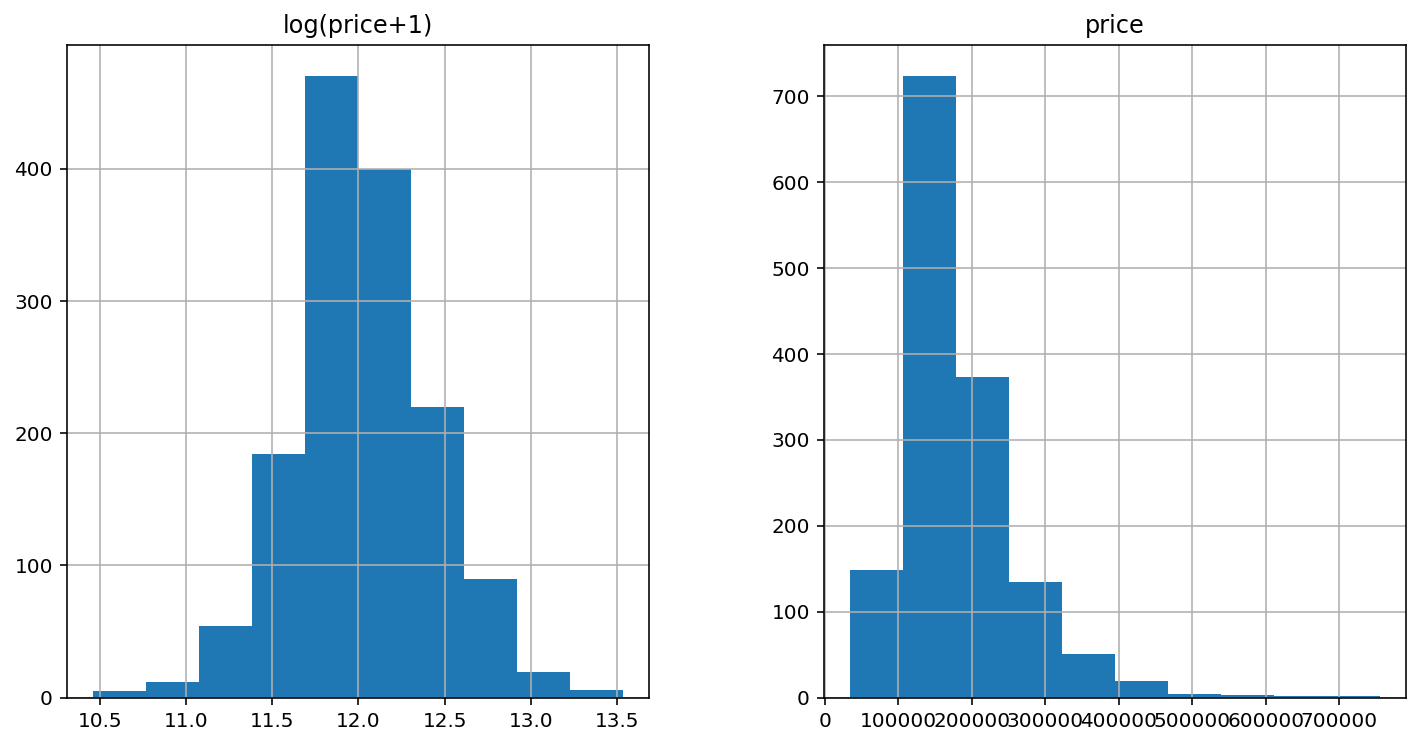

In [8]:
matplotlib.rcParams['figure.figsize']=(12.0,6.0)
#通过使用log将原价格分布转为近似的正态分布
prices = pd.DataFrame({'price':train['SalePrice'],'log(price+1)':np.log1p(train['SalePrice'])})
prices.hist()

In [9]:
#log transform the target:
train['SalePrice'] = np.log1p(train['SalePrice'])
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes !='object'].index
skewed_feats = train[numeric_feats].apply(lambda x:skew(x.dropna()))#compute skewness计算斜度
skewed_feats = skewed_feats[skewed_feats>0.75]
skewed_feats =skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])


In [10]:
all_data = pd.get_dummies(all_data)
#filling Na's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [12]:
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,LassoCV,LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [13]:
model_ridge = Ridge()

In [14]:
alphas = [0.05,0.1,0.3,1,3,5,10,15,30,50,75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
           for alpha in alphas]

Text(0,0.5,'rmse')

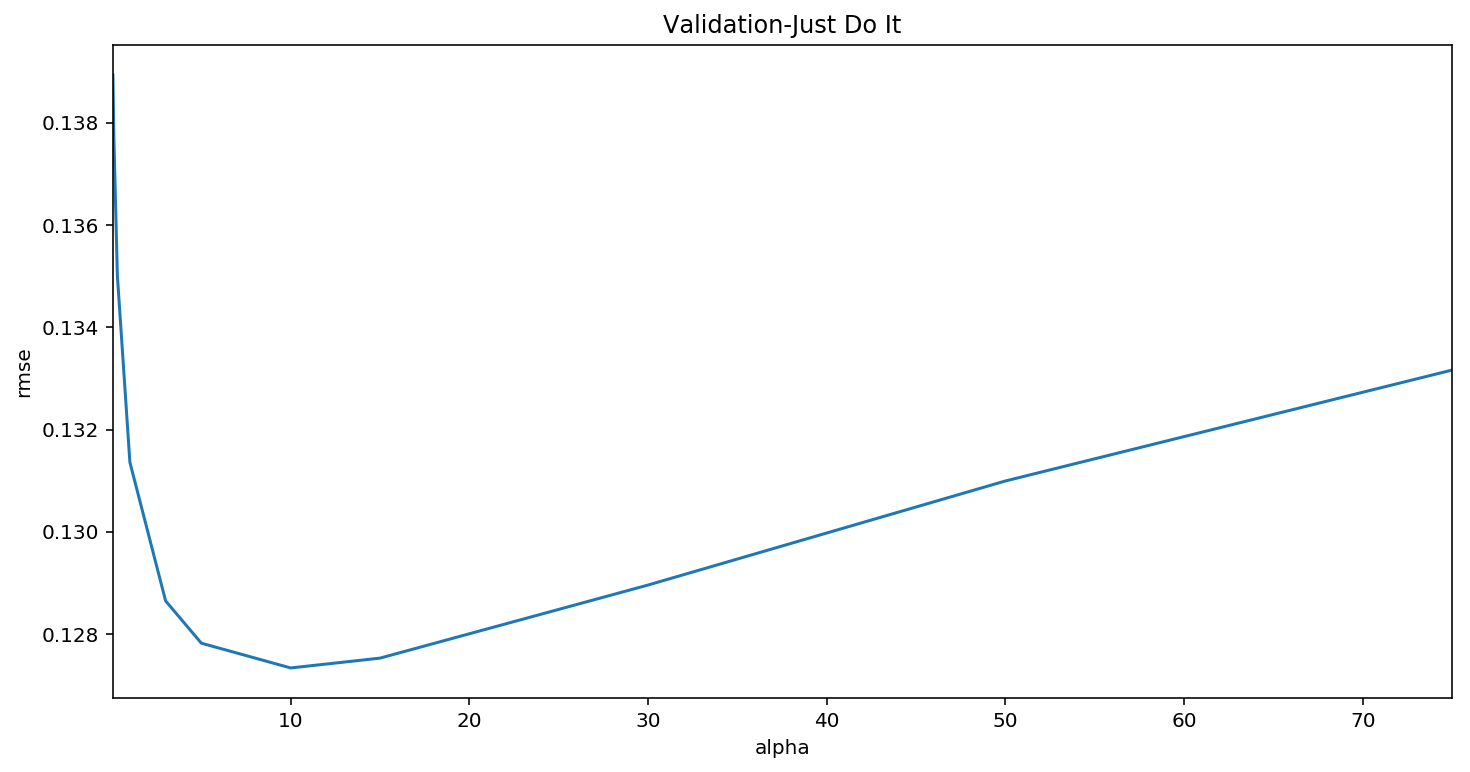

In [15]:
cv_ridge = pd.Series(cv_ridge,index = alphas)
cv_ridge.plot(title='Validation-Just Do It')
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [16]:
print(cv_ridge[10])
cv_ridge.min()

0.127337346687


0.12733734668670788

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [17]:
model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005]).fit(X_train,y)

In [18]:
rmse_cv(model_lasso).mean()
rmse_cv(model_lasso)

array([ 0.10330973,  0.13147319,  0.12552436,  0.10818879,  0.14722499])

可得LassoCV的方法误差小于岭回归,通过Lasso将不相关的系数的权重设为了0，我们可以看一下选择了那些系数

In [19]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [20]:
#打印出系数不为0的项
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print(coef[coef!=0])

Lasso picked 110 variables and eliminated the other 178 variables
MSSubClass              -0.007480
LotArea                  0.071826
OverallQual              0.053160
OverallCond              0.043027
YearBuilt                0.001777
YearRemodAdd             0.000722
MasVnrArea              -0.000194
BsmtFinSF1               0.009292
BsmtFinSF2              -0.001385
BsmtUnfSF               -0.003975
TotalBsmtSF              0.019208
1stFlrSF                 0.030350
2ndFlrSF                -0.003396
LowQualFinSF            -0.003880
GrLivArea                0.400009
BsmtFullBath             0.025674
FullBath                 0.021307
HalfBath                 0.013793
BedroomAbvGr            -0.001004
KitchenAbvGr            -0.009937
TotRmsAbvGrd             0.005079
Fireplaces               0.022117
GarageYrBlt              0.000029
GarageCars               0.038789
GarageArea               0.000051
WoodDeckSF               0.004409
OpenPorchSF              0.001631
EnclosedPorch   

本次训练的选择的有用的特征也并不一定是正确的，因为其中特征有许多是线性相关的，可以通过在Bootstrap样本上多次运行Lasso，稳定的选择功能

In [21]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

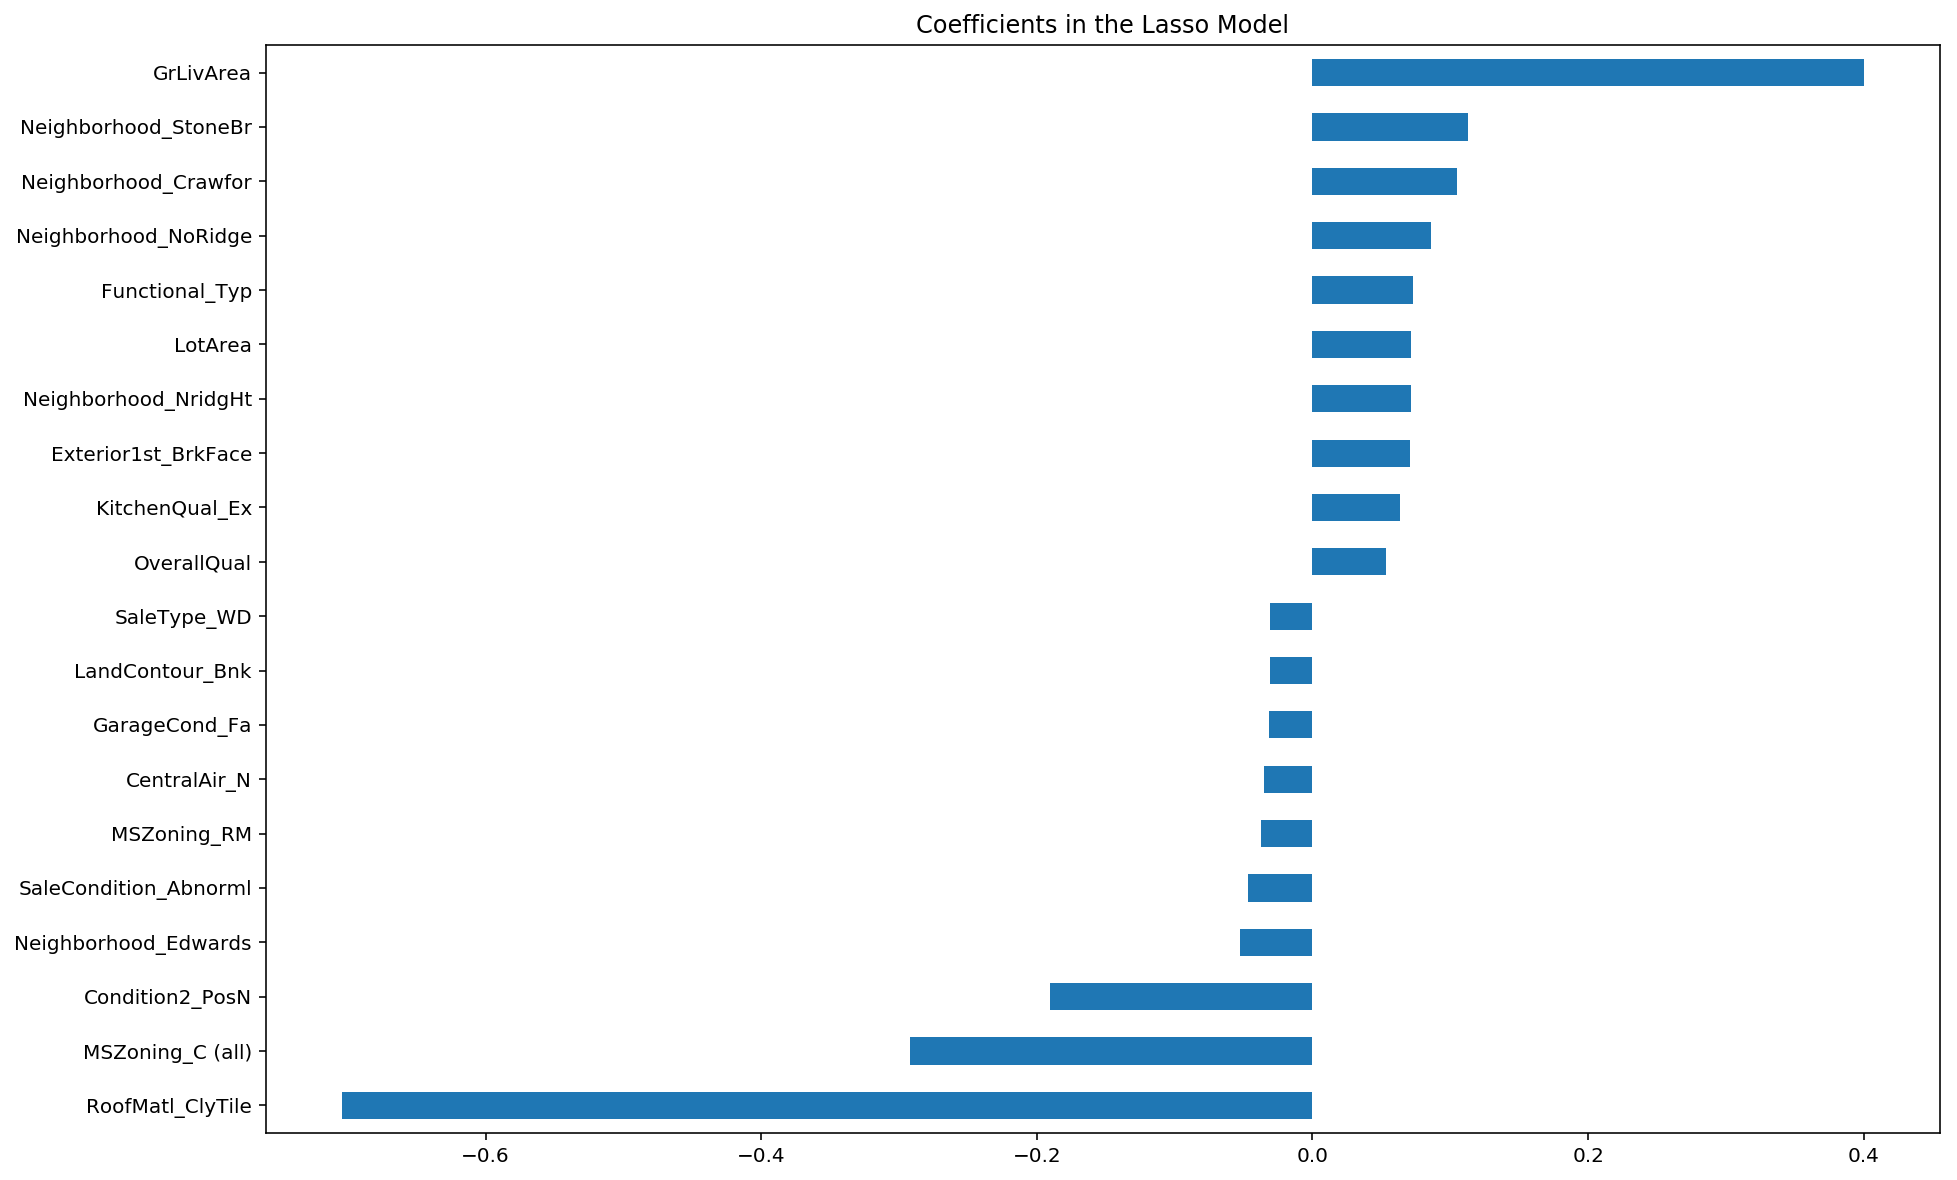

In [22]:
matplotlib.rcParams['figure.figsize']=(15.0,10.0)
imp_coef.plot(kind="barh")
plt.title('Coefficients in the Lasso Model')

由图上可知，最positive的属性为GrLivArea，意义为地面面积按平方英尺算。具有Negetive意义的变量似乎来自不平衡的分类变量

由于所有的属性都是实际属性，应该可以说出为什么系数的影响是这样的。唯一的问题是我们使用了log变换，属性的幅值难以解释

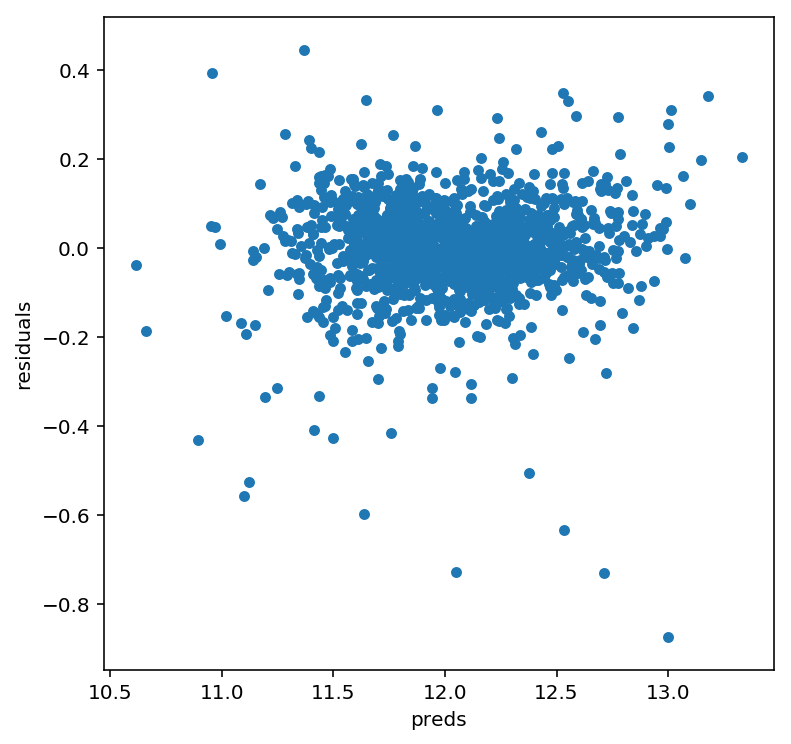

In [23]:
#观察残差，残差：预测值与实际值之差
#设置画图大小
matplotlib.rcParams['figure.figsize']=(6.0,6.0)
preds = pd.DataFrame({'preds':model_lasso.predict(X_train),'true':y})
preds['residuals'] = preds['true']-preds['preds']
preds.plot(x='preds',y='residuals',kind='scatter')

### 添加一个XGboost模型
看其能否改善分数

In [24]:
import xgboost as xgb


C:\Users\MappingLab-lxy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)


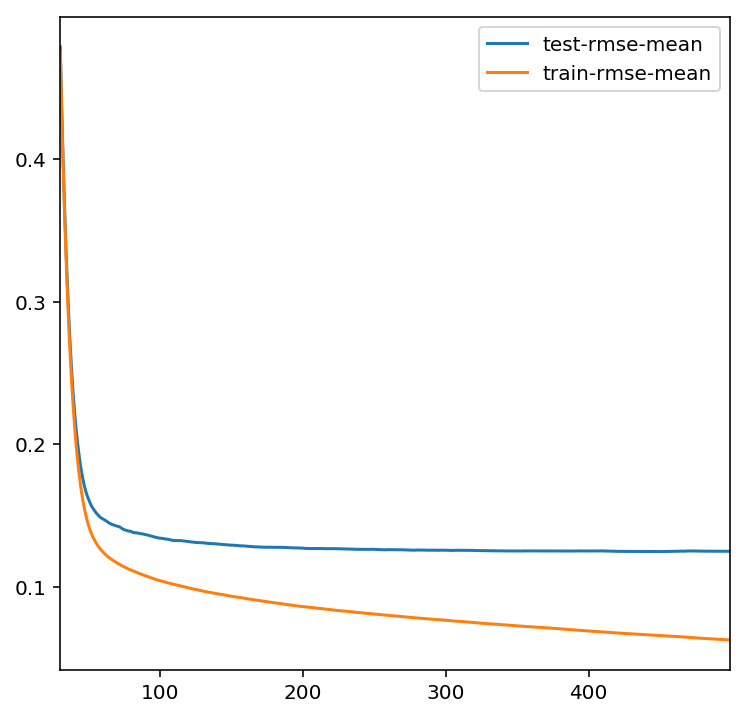

In [26]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [27]:
model_xgb = xgb.XGBRegressor(n_estimators=360,max_depth=2,learning_rate=0.1)#参数调整使用xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [28]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

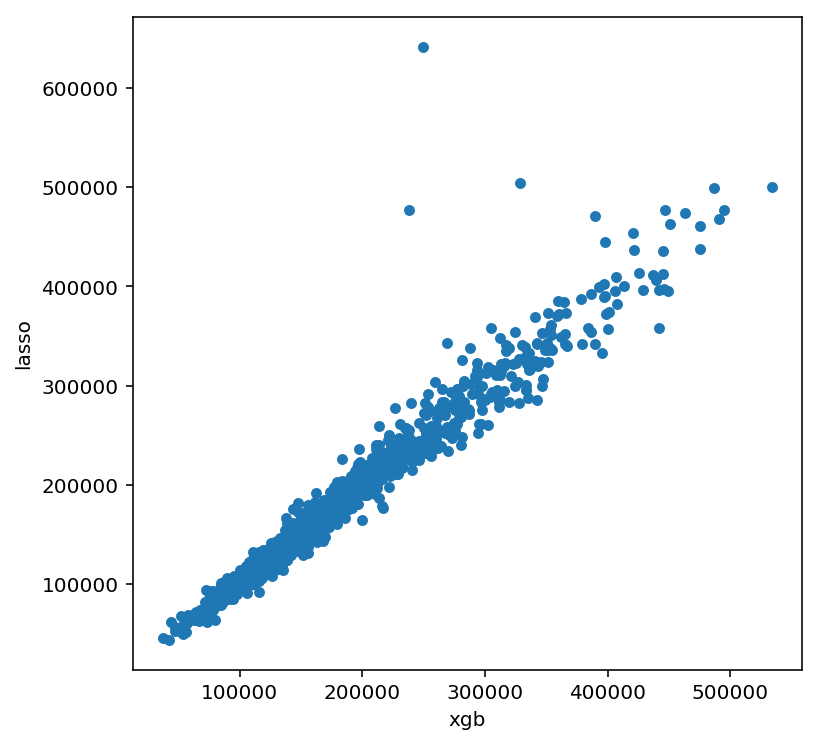

In [29]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

很多时候对不相关的结果进行加权平均值是有意义的 - 这通常会影响分数，尽管在这种情况下它并没有太大的帮助。

In [30]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [31]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

###  Try on keras？
前向神经网络是否奏效

In [32]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [33]:
X_train = StandardScaler().fit_transform(X_train)

In [34]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [35]:
X_tr.shape

(1095, 288)

In [36]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [41]:
model = Sequential()
model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))
model.compile(loss = "mse", optimizer = "adam")

C:\Users\MappingLab-lxy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               73984     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 74,241
Trainable params: 74,241
Non-trainable params: 0
_________________________________________________________________


In [45]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val),epochs=50)

Train on 1095 samples, validate on 365 samples
Epoch 1/50
1095/1095 [==============================] - 0s - loss: 0.1782 - val_loss: 8.9143
Epoch 2/50
1095/1095 [==============================] - 0s - loss: 0.1466 - val_loss: 8.9443
Epoch 3/50
1095/1095 [==============================] - 0s - loss: 0.1266 - val_loss: 8.9302
Epoch 4/50
1095/1095 [==============================] - 0s - loss: 0.1089 - val_loss: 8.9684
Epoch 5/50
1095/1095 [==============================] - 0s - loss: 0.0942 - val_loss: 9.0021
Epoch 6/50
1095/1095 [==============================] - 0s - loss: 0.0825 - val_loss: 9.0074
Epoch 7/50
1095/1095 [==============================] - 0s - loss: 0.0742 - val_loss: 9.0205
Epoch 8/50
1095/1095 [==============================] - 0s - loss: 0.0666 - val_loss: 9.0745
Epoch 9/50
1095/1095 [==============================] - 0s - loss: 0.0615 - val_loss: 9.0606
Epoch 10/50
1095/1095 [==============================] - 0s - loss: 0.0560 - val_loss: 9.0686
Epoch 11/50
1095/1095 

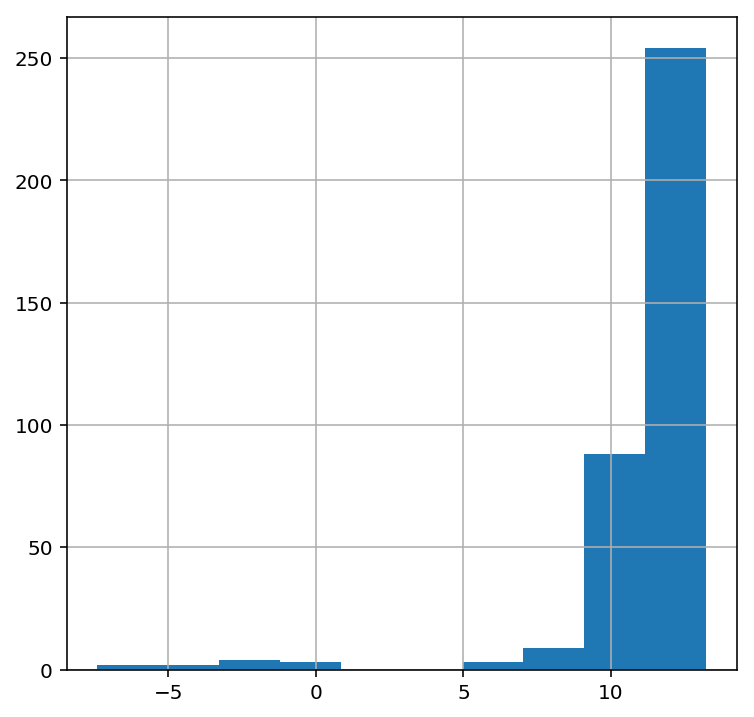

In [46]:
pd.Series(model.predict(X_val)[:,0]).hist()